# OpenJij SA Parameter Dependency Experiment with MINTO

This notebook is a simple experiment to see how the parameters of the Simulated Annealing (SA) algorithm in OpenJij affect the performance of the algorithm.  

The SA algorithm has temperature as a parameter, and OpenJij automatically sets this temperature based on the coefficients of QUBO or Ising models. Let's verify how effective these automatic parameter settings are by using grid search.

Even in grid search cases, using MINTO for logging allows us to easily convert the data to pandas.DataFrame for visualization. This helps us analyze the relationship between different parameter combinations and their impact on solution quality and execution time.

In [1]:
import openjij as oj
import numpy as np
import minto
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Create Random QUBO

In [2]:
def random_qubo(n, sparsity=0.5):
    q = np.random.uniform(-1, 1, (n, n))
    q = (q + q.T) / 2
    zero_num = int(n**2 * sparsity)
    zero_i = np.random.choice(n, zero_num, replace=True)
    zero_j = np.random.choice(n, zero_num, replace=True)
    q[zero_i, zero_j] = 0
    q[zero_j, zero_i] = 0
    qubo = {}
    for i in range(n-1):
        for j in range(i, n):
            qubo[(i, j)] = q[i, j]
            qubo[(j, i)] = q[j, i]
    return qubo


In [3]:
n = 200
q = random_qubo(n)

## 2. Run with default parameters

In OpenJij, you can check the automatically configured SA parameters through `.info['schedule']` in the return value of `.sample_qubo`. These parameters are stored under the key 'schedule' since the temperature settings in SA are referred to as the annealing schedule.

In [4]:
sampler = oj.SASampler()
response = sampler.sample_qubo(q)
schedule = response.info["schedule"]
schedule

{'beta_max': 146262.07805091763,
 'beta_min': 0.03395211324880749,
 'num_sweeps': 1000}

## 3. Grid search with MINTO

Let's see how the optimization results change by varying the inverse temperature parameters of SA. We'll include OpenJij's default parameters in our search range for comparison.

The important values from OpenJij's results are stored using `.log_parameter` method. The complete OpenJij response object is also saved using `.log_object` method with `.to_serializable`.

In [5]:
exp = minto.Experiment(auto_saving=False)

# log_object accepts only serializable objects
# so we need to convert qubo to serializable object
qubo_edges = [[i, j] for i, j in q.keys()]
qubo_vales = [q[i, j] for i, j in qubo_edges]
exp.log_object("qubo", {"qubo_edges": qubo_edges, "qubo_vales": qubo_vales})

beta_min_list = [schedule["beta_min"], 0.1, 1.0, 2.0, 3.0, 4.0, 5.0]
beta_max_list = [10.0, 20, 30.0, 40.0, 50.0, 12404, schedule["beta_max"]]
num_reads = 300

exp.log_parameter("num_reads", num_reads)

for beta_min in beta_min_list:
    for beta_max in beta_max_list:
        with exp.run():
            sampler = oj.SASampler()
            response = exp.log_solver(sampler.sample_qubo)(q, num_reads=num_reads, beta_min=beta_min, beta_max=beta_max)
            exp.log_object("response", response.to_serializable())
            energies = response.energies
            exp.log_parameter("mean_energy", np.mean(energies))
            exp.log_parameter("std_energy", np.std(energies))
            exp.log_parameter("min_energy", np.min(energies))
            exp.log_parameter("exec_time", response.info["execution_time"])

In [6]:
run_table = exp.get_run_table()
run_table

parameter                                                            \
        solver_name num_reads  beta_min       beta_max mean_energy std_energy   
run_id                                                                          
0       sample_qubo       300  0.033952      10.000000 -513.646088   0.213896   
1       sample_qubo       300  0.033952      20.000000 -513.683011   0.195517   
2       sample_qubo       300  0.033952      30.000000 -513.701567   0.181375   
3       sample_qubo       300  0.033952      40.000000 -513.685011   0.196573   
4       sample_qubo       300  0.033952      50.000000 -513.691557   0.196815   
5       sample_qubo       300  0.033952   12404.000000 -513.662848   0.242503   
6       sample_qubo       300  0.033952  146262.078051 -513.646933   0.216257   
7       sample_qubo       300  0.100000      10.000000 -513.656759   0.237213   
8       sample_qubo       300  0.100000      20.000000 -513.691143   0.187984   
9       sample_qubo       300  0.100000      30.000000 -513.707417   0.186051   
10      sample_qubo       300  0.100000      40.000000 -513.708179   0.201705   
11      sample_qubo       300  0.100000      50.000000 -513.716929   0.199913   
12      sample_qubo       300  0.100000   12404.000000 -513.649495   0.257786   
13      sample_qubo       300  0.100000  146262.078051 -513.673241   0.223819   
14      sample_qubo       300  1.000000      10.000000 -513.667470   0.210575   
15      sample_qubo       300  1.000000      20.000000 -513.695942   0.183224   
16      sample_qubo       300  1.000000      30.000000 -513.713585   0.188009   
17      sample_qubo       300  1.000000      40.000000 -513.692656   0.170863   
18      sample_qubo       300  1.000000      50.000000 -513.706433   0.187874   
19      sample_qubo       300  1.000000   12404.000000 -513.684895   0.199205   
20      sample_qubo       300  1.000000  146262.078051 -513.672631   0.204222   
21      sample_qubo       300  2.000000      10.000000 -513.674988   0.203544   
22      sample_qubo       300  2.000000      20.000000 -513.724817   0.179151   
23      sample_qubo       300  2.000000      30.000000 -513.725198   0.167566   
24      sample_qubo       300  2.000000      40.000000 -513.726547   0.167947   
25      sample_qubo       300  2.000000      50.000000 -513.709340   0.170286   
26      sample_qubo       300  2.000000   12404.000000 -513.691366   0.211648   
27      sample_qubo       300  2.000000  146262.078051 -513.687734   0.214674   
28      sample_qubo       300  3.000000      10.000000 -513.685860   0.188711   
29      sample_qubo       300  3.000000      20.000000 -513.723616   0.167433   
30      sample_qubo       300  3.000000      30.000000 -513.725525   0.171873   
31      sample_qubo       300  3.000000      40.000000 -513.718090   0.179684   
32      sample_qubo       300  3.000000      50.000000 -513.720097   0.189601   
33      sample_qubo       300  3.000000   12404.000000 -513.729398   0.210266   
34      sample_qubo       300  3.000000  146262.078051 -513.675086   0.354749   
35      sample_qubo       300  4.000000      10.000000 -513.681077   0.212771   
36      sample_qubo       300  4.000000      20.000000 -513.750501   0.165460   
37      sample_qubo       300  4.000000      30.000000 -513.767667   0.182406   
38      sample_qubo       300  4.000000      40.000000 -513.771701   0.165880   
39      sample_qubo       300  4.000000      50.000000 -513.769045   0.173049   
40      sample_qubo       300  4.000000   12404.000000 -513.672979   0.456536   
41      sample_qubo       300  4.000000  146262.078051 -513.556963   0.717156   
42      sample_qubo       300  5.000000      10.000000 -513.723920   0.185922   
43      sample_qubo       300  5.000000      20.000000 -513.764570   0.163447   
44      sample_qubo       300  5.000000      30.000000 -513.786749   0.167871   
45      sample_qubo       300  5.000000      40.000000 -513.758803   0.215259   
46      sample_qubo       300  5.000000  

## 4. Visualizing the results

Convert the `run_table` to a format suitable for heatmap visualization using pivot method.

MINTO's `.get_run_table()` returns a DataFrame with double-header, so we use `'parameter'` key
to extract the relevant DataFrame and then transform it for heatmap visualization.

In [14]:
param_table = run_table["parameter"].pivot(index="beta_min", columns="beta_max", values="mean_energy")
param_table

beta_max  1.000000e+01  2.000000e+01  3.000000e+01  4.000000e+01  \
beta_min                                                           
0.035392   -453.464982   -453.507494   -453.534059   -453.532953   
0.100000   -453.453971   -453.529594   -453.524856   -453.537001   
1.000000   -453.459997   -453.538323   -453.551997   -453.553772   
2.000000   -453.457537   -453.544244   -453.543310   -453.541399   
3.000000   -453.410358   -453.459166   -453.372327   -453.351138   
4.000000   -453.207369   -453.222023   -453.382031   -453.077857   
5.000000   -453.152222   -453.051467   -453.185958   -453.192416   

beta_max  5.000000e+01  1.240400e+04  1.095377e+06  
beta_min                                            
0.035392   -453.519391   -453.501373   -453.501622  
0.100000   -453.511809   -453.510465   -453.469833  
1.000000   -453.543713   -453.530421   -453.514144  
2.000000   -453.548270   -453.529462   -453.405491  
3.000000   -453.383562   -453.249898   -453.131773  
4.000000   -453.106334   -452.971615   -453.025248  
5.000000   -453.218520   -452.893875   -452.744779

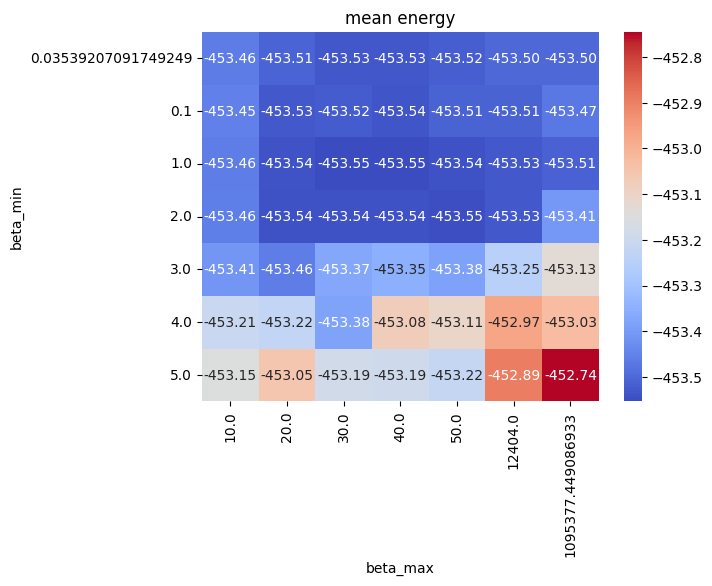

In [15]:
sns.heatmap(param_table, annot=True, fmt="1.2f", cmap="coolwarm")
plt.xlabel("beta_max")
plt.ylabel("beta_min")
plt.title("mean energy")
plt.show()

## 5. Result Analysis

Looking at the results, OpenJij's default parameters are not bad, but there appears to be more optimal parameters around `beta_max=40.0, beta_min=0.1`.

Let's examine another perspective. In OpenJij's algorithm, when a spin flip is rejected, no calculation is performed. When a spin flip occurs, the energy difference is calculated. Therefore, if the temperature is high (inverse temperature beta is low) for a long period, the number of spin flips increases, leading to increased computation time.

As a result, the computation time varies depending on the temperature settings. Let's visualize these results. OpenJij's computation time is measured in microseconds.

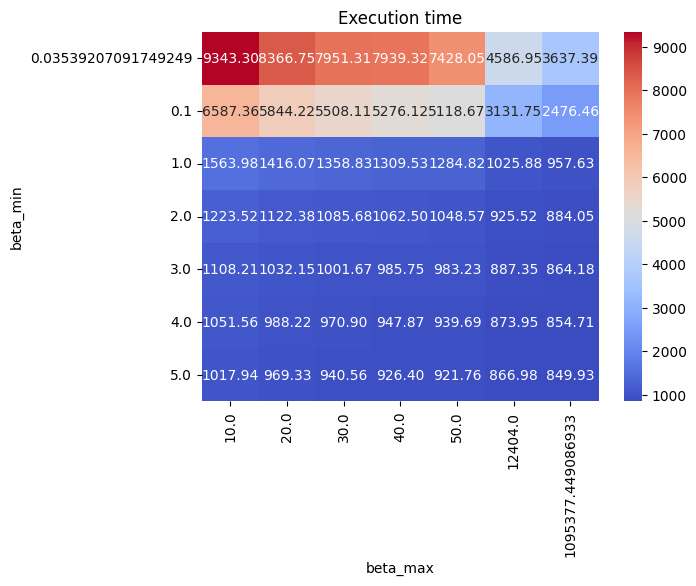

In [16]:
exec_table = run_table["parameter"].pivot(
    index="beta_min", columns="beta_max", values="exec_time"
)
sns.heatmap(exec_table, annot=True, fmt="1.2f", cmap="coolwarm")
plt.xlabel("beta_max")
plt.ylabel("beta_min")
plt.title("Execution time")
plt.show()

# Analysis of OpenJij's Default Parameters

Unfortunately, OpenJij's default parameters (v0.9.1) appear to be suboptimal in terms of computation time.

The temperature parameters are also affected by the `num_sweeps` parameter that controls the number of steps in simulated annealing.

This numerical experiment reveals that there is still room for improvement in OpenJij's temperature parameter settings.

MINTO proves useful in gaining insights about solver parameter configurations.